In [13]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys, math, numpy as N, matplotlib.pyplot as P
from libstempo.libstempo import *
import libstempo
import libstempo.plot as LP, libstempo.toasim as LT
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import libstempo as T
from astropy.stats import LombScargle
import pandas as pd
import subprocess
from mpl_toolkits.axes_grid1 import make_axes_locatable


def add_colorbar_outside_mod(mappable, ax, label=None, **kwargs):
    """
    Add a colorbar outside the plot.

    Parameters:
        mappable (scalar mappable): The image (or other mappable object) 
                                    to which the colorbar applies.
        ax (matplotlib.axes.Axes): The axes to which the colorbar will be added.
        label (str, optional): The label for the colorbar.
        **kwargs: Additional keyword arguments passed to the colorbar function.

    Returns:
        colorbar (matplotlib.colorbar.Colorbar): The colorbar object.
    """
    divider = make_axes_locatable(ax)
    cax = divider.new_horizontal(size="5%", pad=0.05)
    fig = ax.get_figure()
    fig.add_axes(cax)
    colorbar = fig.colorbar(mappable, cax=cax, **kwargs)
    if label:
        colorbar.set_label(label)
        colorbar.ax.set_ylabel(label, fontsize=15) 
    return colorbar

class Model:

    def __init__(self):
        pass
    
    
    
    def lnL(new,toa_err,mask):

        residual=new[mask]
        toaerr=toa_err[mask]*1e-6
        
        likeli=1/np.sqrt(2*np.pi*toaerr**2)*np.exp(-residual**2/(2*toaerr**2))
        log_lik=1
        for l in likeli:
            log_lik=log_lik*l
        lnL=np.log(log_lik)
        
        return lnL

    def red_chisq(origina, new, toa_err, mask):

        residual=np.append(original['res'],new[mask])
        toaerr=np.append(original['err']*1e-6,toa_err[mask]*1e-6)
        chisq=sum(residual**2/toaerr**2)
        return chisq

def add_colorbar_outside(im,ax):
    fig = ax.get_figure()
    bbox = ax.get_position() #bbox contains the [x0 (left), y0 (bottom), x1 (right), y1 (top)] of the axis.
    width = 0.05
    eps = 0.01 #margin between plot and colorbar
    # [left most position, bottom position, width, height] of color bar.
    cax = fig.add_axes([bbox.x1 + eps, bbox.y0, width, bbox.height])
    cbar = fig.colorbar(im, cax=cax)

class toa:

    def __init__(self):
        pass    

    def mjd(data):
        mjd_scat=data.satDay()+data.satSec()
        return mjd_scat    

    def res(data):
        res=data.residuals()
        return res   

    def err(data):
        toaerr=data.toaerrs
        return toaerr*1e-6 


In [16]:

# generate simulation
pbdot_wo=1.46e-14



# number of realizations
num_sim=80
sel=3
ef_cntrl=1.2
meerkat_extension=60675
phase_ska=61465
days=90
obs_random_interval=0.3
mk_rms=4.76
pk_rms=10.341

status=1
#location of index of mjd where you want to inspect

start=meerkat_extension

# call files and make observed arrays

original=pd.read_csv('original.csv')

res=original['res']
toas=original['toa']
err=original['err']


lnL_appender=np.zeros(0)

# generate fake observation for simulation.
obs_days=np.arange(meerkat_extension,69160,days)
rand_obs=obs_random_interval*days*np.random.randn(len(obs_days))
obs_day=obs_days+rand_obs
mjd_range=np.append(toas,obs_day)
phase1=(mjd_range>=meerkat_extension) & (mjd_range<phase_ska)
phase2=(mjd_range>=phase_ska)

phase1_rms=mk_rms*0.72
phase2_rms=mk_rms*0.28
err_set=np.concatenate((np.array(err),np.array([phase1_rms]*len(phase1[phase1==True])),
                               np.array([phase2_rms]*len(phase2[phase2==True]))))

index_loc=np.array([i for i in range(535,len(err_set)-5,10)])

#generate realizations

res_fit_val=np.zeros(0)
res_fit_err=np.zeros(0)
mjd_fit_loc=np.zeros(0)

for i in range(0,num_sim):
    #generate fake datasets for two cases

    #rand_obs=0.3*days*np.random.randn(len(obs_days))
    sim = LT.fakepulsar(parfile='sim_wt_pbd.par',
                            obstimes=mjd_range,  
                            toaerr=err_set)

    LT.add_efac(sim,efac=ef_cntrl)
    wt_res=sim.residuals()
    
    sim_wo = LT.fakepulsar(parfile='sim_wt_pbd.par',
                            obstimes=mjd_range,  
                            toaerr=err_set)

    sim_wo['PBDOT'].val=pbdot_wo
    sim_wo['PBDOT'].fit = False
    LT.add_efac(sim_wo,efac=ef_cntrl)
    wo_res=sim_wo.residuals()
    

    
    sim_wo_prefit = LT.fakepulsar(parfile='sim_wt_pbd.par',
                            obstimes=mjd_range,  
                            toaerr=err_set)
    sim_wo_prefit['PB'].fit = True  
    sim_wo_prefit['RAJ'].fit = True
    sim_wo_prefit['DECJ'].fit = True
    sim_wo_prefit['EPS1'].fit = True
    sim_wo_prefit['EPS2'].fit = True
    sim_wo_prefit['TASC'].fit = True
    sim_wo_prefit['A1'].fit = True

    for i in range(0,3):
        ret = sim_wo_prefit.fit()
    #sim_wo_prefit['PBDOT'].val=5.847219647852672e-15
    #sim_wo_prefit['PBDOT'].fit = False
    #for i in range(0,3):
    #    ret = sim_wo_prefit.fit()
    LT.add_efac(sim_wo_prefit,efac=ef_cntrl)
    wo_prefit_res=sim_wo_prefit.residuals()    

# 545 is the maximum length of the tim file

    sim_wo_prefit.savetim('iteration.tim')    
        
    lnL=[]

    #calculate ICs at each satDay.
        

    for mjd in mjd_range:
        if mjd==mjd_range[0]:
            pass
        else:
            model_wo=  Model.lnL(wo_res,err_set,(mjd_range<mjd))#,'wo_pbdot')  
            model_wt=  Model.lnL(wt_res,err_set,(mjd_range<mjd))#,'wt_pbdot')


            lnL=lnL+[-model_wo+model_wt]
            
    for fit_point in index_loc:
        data=pd.read_csv('iteration.tim',skiprows=[i for i in range(fit_point,len(err_set))])
        pd.DataFrame(data).to_csv('iteration_sub.tim', index=None)
        sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')

        sim_wo_ft['PB'].fit = True  
        sim_wo_ft['RAJ'].fit = True
        sim_wo_ft['DECJ'].fit = True
        sim_wo_ft['EPS1'].fit = True
        sim_wo_ft['EPS2'].fit = True
        #sim_wo_ft['TASC'].fit = True
        sim_wo_ft['A1'].fit = True
        sim_wo_ft['PBDOT'].val=5.847219647852672e-15
        for i in range(0,3):
            ret = sim_wo_ft.fit()
        sim_wo_ft['PBDOT'].fit = True
        for i in range(0,3):
            ret = sim_wo_ft.fit()
        res_fit_val=np.append(res_fit_val,sim_wo_ft['PBDOT'].val)
        res_fit_err=np.append(res_fit_err,sim_wo_ft['PBDOT'].err)
    
    #append ICs at each realization

    lnL_appender=np.append(lnL_appender,np.array(lnL))
    print('%s per %s'%(status,num_sim))
    status=status+1        
    
mjd_range_chisq=mjd_range[1:] 
num_mjd=len(mjd_range_chisq)       

# calculate mean, std of ICs at each mjd.

lnL_mean=lnL_appender.reshape(num_sim,num_mjd).mean(axis=0)
lnL_std=lnL_appender.reshape(num_sim,num_mjd).std(axis=0)



min_lnL_range=lnL_mean-lnL_std
max_lnL_range=lnL_mean+lnL_std



/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

1 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

2 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

3 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

4 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

5 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

6 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

7 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

8 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

9 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

10 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

11 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

12 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

13 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

14 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

15 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

16 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

17 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

18 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

19 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

20 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

21 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

22 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

23 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

24 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

25 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

26 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

27 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

28 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

29 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

30 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

31 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

32 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

33 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

34 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

35 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

36 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

37 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

38 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

39 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

40 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

41 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

42 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

43 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

44 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

45 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

46 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

47 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

48 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

49 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

50 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

51 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

52 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

53 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

54 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

55 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

56 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

57 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

58 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

59 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

60 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

61 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

62 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

63 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

64 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

65 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

66 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

67 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

68 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

69 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

70 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

71 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

72 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

73 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

74 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

75 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

76 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

77 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

78 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

79 per 80


/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_61419/3737954191.py:118: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  sim_wo_ft=T.tempopulsar('sim_wt_pbd.par','iteration_sub.tim')
/tmp/ipykernel_

80 per 80


/home/jiwoong/anaconda3/envs/libstempo/lib/python3.9/site-packages/numpy/ma/core.py:6849: RuntimeWarning: overflow encountered in power
  result = np.where(m, fa, umath.power(fa, fb)).view(basetype)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


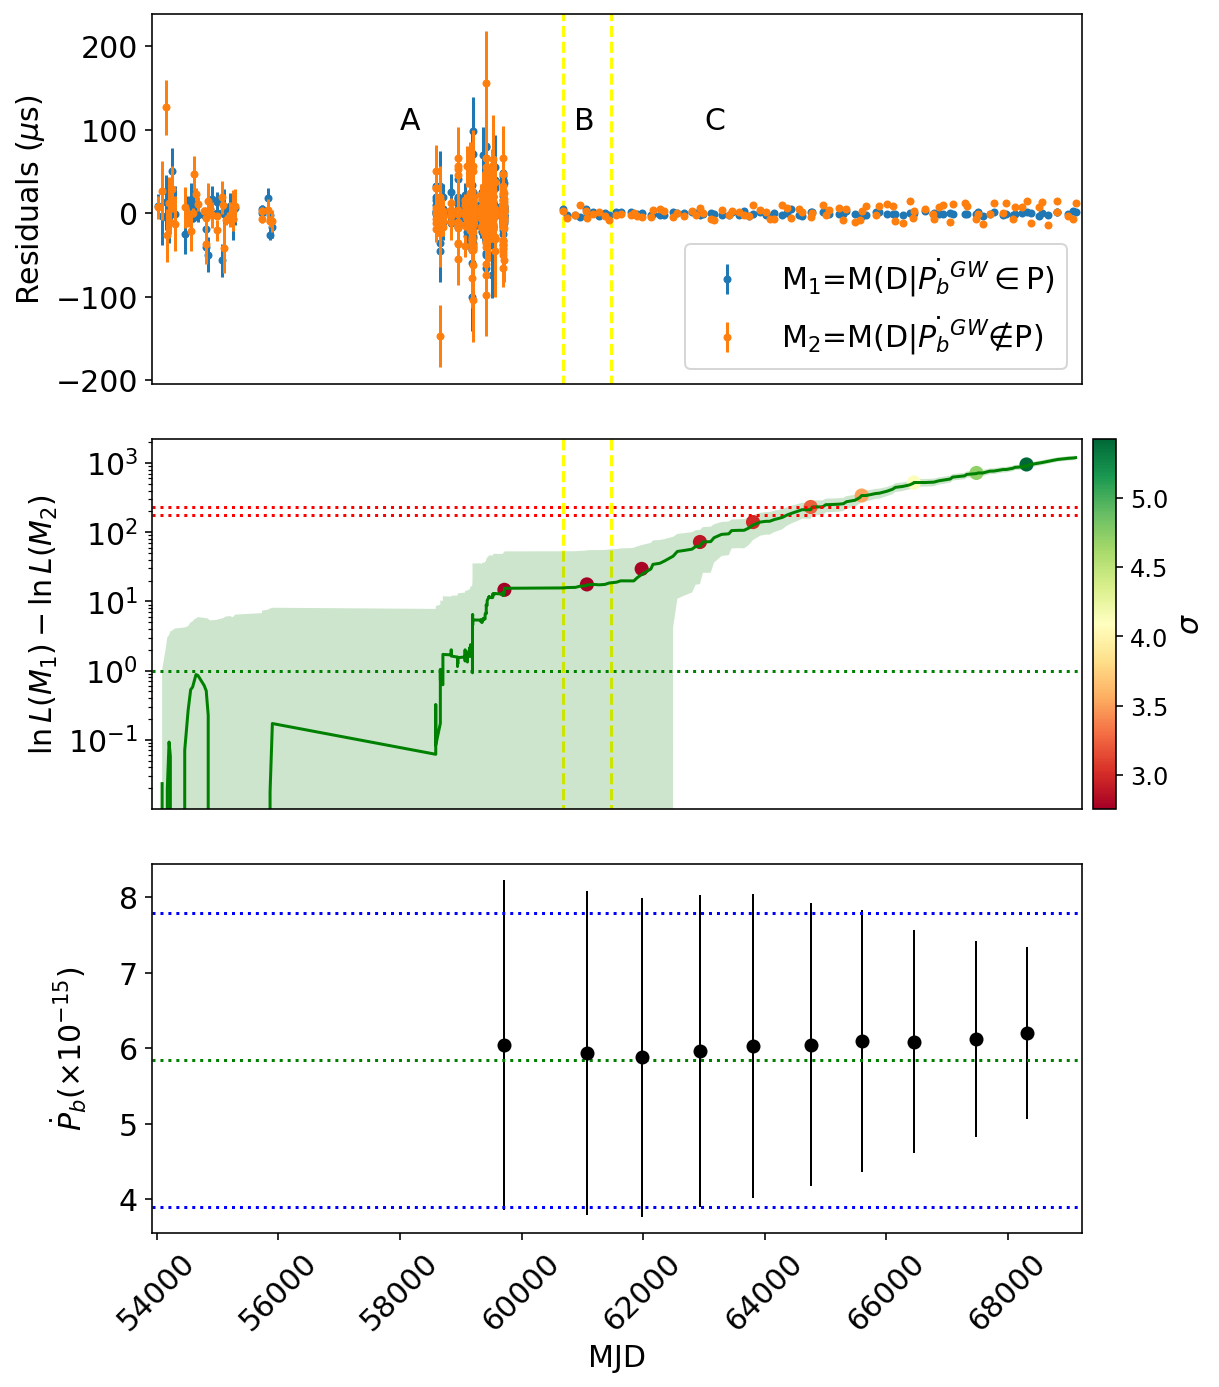

In [24]:
somecondition = True
sel = 3
fig, axs = plt.subplots(3, 1, figsize=(12, 15))  # Create subplots

if not somecondition:
    ax = axs[0]  # Always create the first subplot
    ax.plot(list1)  # Populate the "main" subplot
else:
    ax = axs[0]
    ax.errorbar(mjd_range, wt_res * 1e+6, err_set, fmt='.', label=r'M$_{1}$=M(D|$\dot{P_{b}}^{GW}\in$P)')
    ax.errorbar(mjd_range, wo_res * 1e+6, err_set, fmt='.', label=r'M$_{2}$=M(D|$\dot{P_{b}}^{GW}\notin$P)', zorder=100)

    # plot upgrade 
    ax.axvline(meerkat_extension, ymin=-60, ymax=60, linestyle='--', color='yellow')
    ax.axvline(phase_ska, ymin=-60, ymax=60, linestyle='--', color='yellow')
    ax.text(63000, 100, 'C', fontsize=15)
    ax.text(60870, 100, 'B', fontsize=15)
    ax.text(58000, 100, 'A', fontsize=15)

    ax.set_xticks([])
    ax.set_ylabel('Residuals ($\mu$s)', fontsize=15)
    ax.set_xlim(min(original['toa']) - 100, max(mjd_range) + 100)
    ax.tick_params(axis='y', labelsize=15)
    ax.legend(fontsize=15,loc='lower right')
    ax.set_rasterized(True)
    # other plot settings...

    ax = axs[1]
    ax.set_xticks([])
    ax.figure.set_size_inches(8, 10)
    ax.figure.set_size_inches(8, 10)
    ax.axhline(1, xmin=0, xmax=69000, linestyle=':', color='g')
    sel_model = min(mjd_range_chisq[(lnL_mean / lnL_std) > sel])
    ax.axhline(min(lnL_mean[mjd_range_chisq > sel_model]), xmin=0, xmax=69000, linestyle=':', color='r')
    ax.set_xlim(min(original['toa']) - 100, max(mjd_range) + 100)
    ax.set_yscale('log')
    ax.fill_between(mjd_range_chisq, min_lnL_range, max_lnL_range,
                     facecolor="green", alpha=0.2)
    ax.plot(mjd_range_chisq, lnL_mean, color='green')

    ax.axvline(meerkat_extension, ymin=-60, ymax=60, linestyle='--', color='yellow', zorder=-100)
    ax.axvline(phase_ska, ymin=-60, ymax=60, linestyle='--', color='yellow', zorder=-100)


    Z_mjd = mjd_range[0:][index_loc]
    mask = [np.around(i, 3) in np.around(Z_mjd, 3) for i in np.around(mjd_range[1:], 3)]

    pbd_measure = res_fit_val.reshape(num_sim, len(index_loc)).mean(axis=0)
    pbd_err = res_fit_err.reshape(num_sim, len(index_loc)).mean(axis=0)

    mask = [i in Z_mjd for i in mjd_range[1:]]
    min_lnL_cb = min_lnL_range[mask]
    max_lnL_cb = max_lnL_range[mask]

    Z = abs(pbd_measure / pbd_err)

    color = ax.scatter(Z_mjd, lnL_mean[index_loc], edgecolors='none', s=50, c=Z, cmap='RdYlGn')

    ax.axhline(min(lnL_mean[index_loc][Z > sel]), xmin=0, xmax=69000, linestyle=':', color='r')
    ax.set_ylabel(r'$\ln{L(M_{1})}-\ln{L(M_{2})}$', fontsize=15)
    ax.set_xlim(min(original['toa']) - 100, max(mjd_range) + 100)
    ax.legend(fontsize=15)
    ax.tick_params(axis='both', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_rasterized(True)
    ax.legend().set_visible(False)

    # other plot settings...

    ax = axs[2]
    ax.set_xlim(min(original['toa']) - 100, max(mjd_range) + 100)
    ax.errorbar(Z_mjd, pbd_measure * 1e+15, pbd_err * 1e+15, fmt='o', color='k',lw=1, label=None)
    ax.set_xlabel('MJD', fontsize=15)
    ax.set_ylabel(r'$\dot{P}_{b} (\times 10^{-15})$', fontsize=15, labelpad=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.legend(fontsize=15)
    ax.set_rasterized(True)
    #y_ticks = np.linspace(1, 10.6, 12)
    #y_ticklabels = ['{}'.format(i) for i in range(1, 24,2)]
    #plt.yticks(y_ticks, y_ticklabels)
    ax.tick_params(axis='x', labelsize=15, rotation=45)
    ax.axhline(5.847219647852672+5.847219647852672/3, xmin=0, xmax=69000, linestyle=':', color='blue')
    ax.axhline(5.847219647852672-5.847219647852672/3, xmin=0, xmax=69000, linestyle=':', color='blue')
    ax.axhline(5.847219647852672, xmin=0, xmax=69000, linestyle=':', color='green')
    ax.legend().set_visible(False)
    # other plot settings...

# Adjust layout
plt.tight_layout(pad=2.0)

# Find the height of the middle panel
bbox = axs[1].get_position()
middle_panel_height = bbox.y1 - bbox.y0

# Create color bar beside the middle panel
cax = fig.add_axes([bbox.x1 + 0.01, bbox.y0, 0.02, middle_panel_height])
cbar = plt.colorbar(color, cax=cax)
cbar.ax.tick_params(labelsize=12)
cbar.set_label(r'$\sigma$', fontsize=15)
plt.savefig('forecast.pdf', bbox_inches='tight', dpi=120)    
plt.show()